In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import signal
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.cm as cm

import math
import pandas as pd
from pandas import DataFrame, read_csv
import pylab as pl

In [2]:
""" 
Little helper function to load data from a .trc binary file.
This is the file format used by LeCroy oscilloscopes.
M. Betz 09/2015
"""
import datetime
import numpy as np
import struct

def readTrc( fName ):
    """
        Reads .trc binary files from LeCroy Oscilloscopes.
        Decoding is based on LECROY_2_3 template.
        [More info](http://forums.ni.com/attachments/ni/60/4652/2/LeCroyWaveformTemplate_2_3.pdf)
        
        Parameters
        -----------       
        fName = filename of the .trc file
        
        Returns
        -----------       
        x: array with sample times [s],
        
        y: array with sample  values [V],
        
        d: dictionary with metadata
        
        
        M. Betz 09/2015
    """
    with open(fName, "rb") as fid:
        data = fid.read(50).decode()
        wdOffset = data.find('WAVEDESC')
        
        #------------------------
        # Get binary format / endianess
        #------------------------
        if readX( fid, '?', wdOffset + 32 ):  #16 or 8 bit sample format?
            smplFmt = "int16"
        else:
            smplFmt = "int8"
        if readX( fid, '?', wdOffset + 34 ):  #Big or little endian?
            endi = "<"
        else:
            endi = ">"
            
        #------------------------
        # Get length of blocks and arrays:
        #------------------------
        lWAVE_DESCRIPTOR = readX( fid, endi+"l", wdOffset + 36 )
        lUSER_TEXT       = readX( fid, endi+"l", wdOffset + 40 )
        lTRIGTIME_ARRAY  = readX( fid, endi+"l", wdOffset + 48 )
        lRIS_TIME_ARRAY  = readX( fid, endi+"l", wdOffset + 52 )
        lWAVE_ARRAY_1    = readX( fid, endi+"l", wdOffset + 60 )
        lWAVE_ARRAY_2    = readX( fid, endi+"l", wdOffset + 64 )

        d = dict()  #Will store all the extracted Metadata
        
        #------------------------
        # Get Instrument info
        #------------------------
        d["INSTRUMENT_NAME"]  = readX( fid, "16s",    wdOffset + 76 ).decode().split('\x00')[0]
        d["INSTRUMENT_NUMBER"]= readX( fid, endi+"l", wdOffset + 92 )
        d["TRACE_LABEL"]      = readX( fid, "16s",    wdOffset + 96 ).decode().split('\x00')[0]
        
        #------------------------
        # Get Waveform info      
        #------------------------
        d["WAVE_ARRAY_COUNT"] = readX( fid, endi+"l", wdOffset +116 )
        d["PNTS_PER_SCREEN"]  = readX( fid, endi+"l", wdOffset +120 )
        d["FIRST_VALID_PNT"]  = readX( fid, endi+"l", wdOffset +124 )
        d["LAST_VALID_PNT"]   = readX( fid, endi+"l", wdOffset +128 )
        d["FIRST_POINT"]      = readX( fid, endi+"l", wdOffset +132 )
        d["SPARSING_FACTOR"]  = readX( fid, endi+"l", wdOffset +136 )
        d["SEGMENT_INDEX"]    = readX( fid, endi+"l", wdOffset +140 )
        d["SUBARRAY_COUNT"]   = readX( fid, endi+"l", wdOffset +144 )
        d["SWEEPS_PER_ACQ"]   = readX( fid, endi+"l", wdOffset +148 )
        d["POINTS_PER_PAIR"]  = readX( fid, endi+"h", wdOffset +152 )
        d["PAIR_OFFSET"]      = readX( fid, endi+"h", wdOffset +154 )
        d["VERTICAL_GAIN"]    = readX( fid, endi+"f", wdOffset +156 ) #to get floating values from raw data :
        d["VERTICAL_OFFSET"]  = readX( fid, endi+"f", wdOffset +160 ) #VERTICAL_GAIN * data - VERTICAL_OFFSET 
        d["MAX_VALUE"]        = readX( fid, endi+"f", wdOffset +164 )
        d["MIN_VALUE"]        = readX( fid, endi+"f", wdOffset +168 )
        d["NOMINAL_BITS"]     = readX( fid, endi+"h", wdOffset +172 )
        d["NOM_SUBARRAY_COUNT"]= readX( fid, endi+"h",wdOffset +174 )
        d["HORIZ_INTERVAL"]   = readX( fid, endi+"f", wdOffset +176 ) #sampling interval for time domain waveforms 
        d["HORIZ_OFFSET"]     = readX( fid, endi+"d", wdOffset +180 ) #trigger offset for the first sweep of the trigger, seconds between the trigger and the first data point 
        d["PIXEL_OFFSET"]     = readX( fid, endi+"d", wdOffset +188 )
        d["VERTUNIT"]         = readX( fid, "48s", wdOffset +196 ).decode().split('\x00')[0]
        d["HORUNIT"]          = readX( fid, "48s", wdOffset +244 ).decode().split('\x00')[0]
        d["HORIZ_UNCERTAINTY"]= readX( fid, endi+"f", wdOffset +292 )
        d["TRIGGER_TIME"]     = getTimeStamp( fid, endi, wdOffset +296 )
        d["ACQ_DURATION"]     = readX( fid, endi+"f", wdOffset +312 )
        d["RECORD_TYPE"]      = ["single_sweep","interleaved","histogram","graph","filter_coefficient","complex","extrema","sequence_obsolete","centered_RIS","peak_detect"][ readX( fid, endi+"H", wdOffset +316 ) ]
        d["PROCESSING_DONE"]  = ["no_processing","fir_filter","interpolated","sparsed","autoscaled","no_result","rolling","cumulative"][ readX( fid, endi+"H", wdOffset +318 ) ]
        d["RIS_SWEEPS"]       = readX( fid, endi+"h", wdOffset +322 )
        d["TIMEBASE"]         = ['1_ps/div', '2_ps/div', '5_ps/div', '10_ps/div', '20_ps/div', '50_ps/div', '100_ps/div', '200_ps/div', '500_ps/div', '1_ns/div', '2_ns/div', '5_ns/div', '10_ns/div', '20_ns/div', '50_ns/div', '100_ns/div', '200_ns/div', '500_ns/div', '1_us/div', '2_us/div', '5_us/div', '10_us/div', '20_us/div', '50_us/div', '100_us/div', '200_us/div', '500_us/div', '1_ms/div', '2_ms/div', '5_ms/div', '10_ms/div', '20_ms/div', '50_ms/div', '100_ms/div', '200_ms/div', '500_ms/div', '1_s/div', '2_s/div', '5_s/div', '10_s/div', '20_s/div', '50_s/div', '100_s/div', '200_s/div', '500_s/div', '1_ks/div', '2_ks/div', '5_ks/div', 'EXTERNAL'][ readX( fid, endi+"H", wdOffset +324 ) ]
        d["VERT_COUPLING"]    = ['DC_50_Ohms', 'ground', 'DC_1MOhm', 'ground', 'AC,_1MOhm'][ readX( fid, endi+"H", wdOffset +326 ) ]
        d["PROBE_ATT"]        = readX( fid, endi+"f", wdOffset +328 )
        d["FIXED_VERT_GAIN"]  = ['1_uV/div','2_uV/div','5_uV/div','10_uV/div','20_uV/div','50_uV/div','100_uV/div','200_uV/div','500_uV/div','1_mV/div','2_mV/div','5_mV/div','10_mV/div','20_mV/div','50_mV/div','100_mV/div','200_mV/div','500_mV/div','1_V/div','2_V/div','5_V/div','10_V/div','20_V/div','50_V/div','100_V/div','200_V/div','500_V/div','1_kV/div'][ readX( fid, endi+"H", wdOffset +332 ) ]
        d["BANDWIDTH_LIMIT"]  = ['off', 'on'][ readX( fid, endi+"H", wdOffset +334 ) ]
        d["VERTICAL_VERNIER"] = readX( fid, endi+"f", wdOffset +336 )
        d["ACQ_VERT_OFFSET"]  = readX( fid, endi+"f", wdOffset +340 )
        d["WAVE_SOURCE"]      = readX( fid, endi+"H", wdOffset +344 )
        d["USER_TEXT"]        = readX( fid, "{0}s".format(lUSER_TEXT), wdOffset + lWAVE_DESCRIPTOR ).decode().split('\x00')[0]

        #------------------------
        # Get main sample data with the help of numpys .fromfile(
        #------------------------
        fid.seek( wdOffset + lWAVE_DESCRIPTOR + lUSER_TEXT + lTRIGTIME_ARRAY + lRIS_TIME_ARRAY ) #Seek to WAVE_ARRAY_1
        y = np.fromfile( fid, smplFmt, lWAVE_ARRAY_1 )
        if endi == ">":
            y.byteswap( True )
        y = d["VERTICAL_GAIN"] * y - d["VERTICAL_OFFSET"]
        x = np.arange(1,len(y)+1)*d["HORIZ_INTERVAL"] + d["HORIZ_OFFSET"]
    return x, y, d

def readX( fid, fmt, adr=None ):
    """ extract a byte / word / float / double from the binary file """
    nBytes = struct.calcsize( fmt )
    if adr is not None:
        fid.seek( adr )
    s = struct.unpack( fmt, fid.read( nBytes ) )
    if(type(s) == tuple):
        return s[0]
    else:
        return s

def getTimeStamp( fid, endi, adr ):
    """ extract a timestamp from the binary file """
    s = readX( fid, endi+"d", adr )
    m = readX( fid, endi+"b" )
    h = readX( fid, endi+"b" )
    D = readX( fid, endi+"b" )
    M = readX( fid, endi+"b" )
    Y = readX( fid, endi+"h" )
    trigTs = datetime.datetime(Y, M, D, h, m, int(s), int((s-int(s))*1e6) )
    return trigTs

In [3]:
cd /Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/

/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018


In [4]:
pressure = glob.glob('*bar')
pressure

['0.75bar', '1bar', '5bar', '4bar', '7bar', '3bar', '2bar', '6bar']

In [5]:
pathM= "/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/" + pressure[1]
paths=glob.glob(pathM+"/*0")
paths

['/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/3000',
 '/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/1500',
 '/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/2000',
 '/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/1000',
 '/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/3500',
 '/Users/austinmcdonald/Desktop/data/BTX-Ion/NoAmp/Ar-ion-043018/1bar/2500']

In [6]:
#%%time
dataX=[]
dataY=[]
XTraces=dict()
YTraces=dict()
volt = dict()
time = dict()
for z in range(0,len(paths)):
    dataX=[]
    dataY=[]
    Files = os.listdir(paths[z])
    for x in range(0,len(Files)):
        datX, datY, info = readTrc(paths[z]+"/"+Files[x])
        NTraces     =   info['SUBARRAY_COUNT']
        TotalPoints =   info[ 'WAVE_ARRAY_COUNT']
        dx          =   info['HORIZ_INTERVAL']
        PPT         =   TotalPoints/NTraces
        YTraces[x]   =   np.split(datY, NTraces)
        XTraces[x]   =   np.split(datX, NTraces)
        for y in range(0,len(YTraces[x])):
            dataX.append(XTraces[x][y][0:2500000])
            dataY.append(YTraces[x][y][0:2500000])
    volt[z] = np.array(dataY)
    time[z] = np.array(dataX)

In [7]:
Efield=np.array([1000,1500,2000,2500,3000,3500])/20

In [8]:
Volt = dict()
STD  = dict()
Time = dict()
for x in range(0,len(paths)):
    Volt[x] = np.mean(volt[x],axis=0)
    STD[x] = np.std(volt[x],axis=0)
    Time[x] = time[x][0]
#   Efield.append(float(Folders[x])/20)

In [9]:
len(Volt)

6

In [10]:
Efield

array([  50.,   75.,  100.,  125.,  150.,  175.])

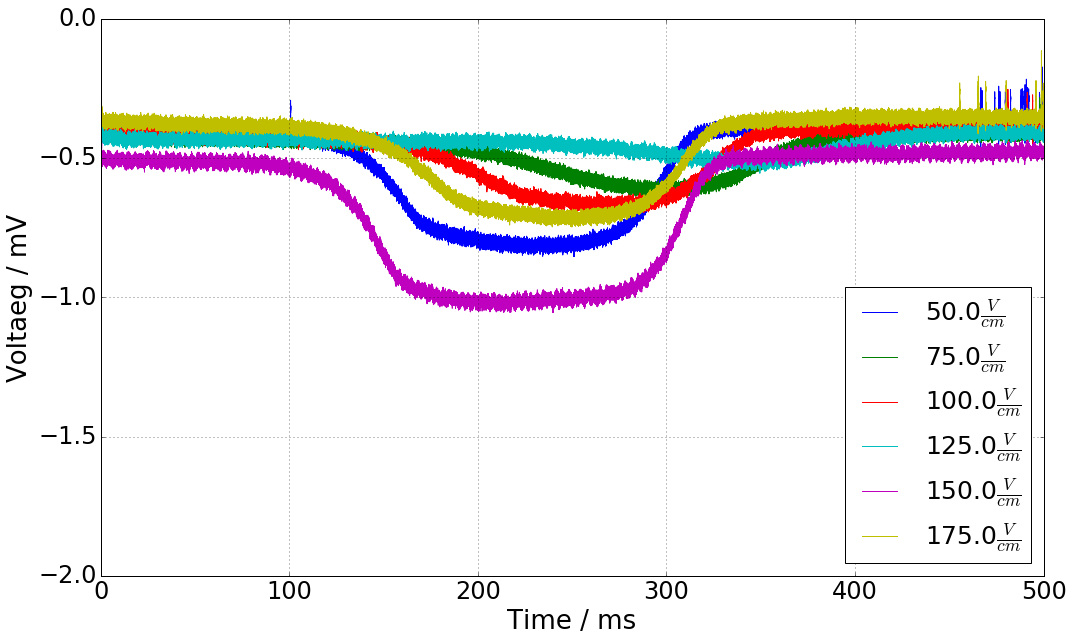

In [12]:
mu = 1e6
ml = 1e3
unit=  r"$\frac{V}{cm}$"
plt.figure(figsize=(15,9))
for x in range(0,len(paths)):
    plt.plot(savgol_filter(Time[x],11,3)*ml,savgol_filter(Volt[x],11,3)*ml,label=str(Efield[x]) + unit)
#plt.text(325, -10, r'750 Torr', fontsize=30)
#plt.text(25, -1.5, r'RC=1s', fontsize=30)
#plt.title('BTX ION drift 5-24-17 ',fontsize=30)
#plt.xlim(-10,250)
plt.ylim(-2,0)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltaeg / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_ION_5-18-17-2.pdf')

plt.show()

In [186]:
ct = 1.8e6
mu = 1e6
ml = 1e3
VoltCorr = dict()
TimeCorr = dict()
leng = len(Volt)
for x in range(0,leng):
    TimeCorr[x] = (Time[x]*ml)[0:ct]
    vv =Volt[x]#+abs(np.mean(Volt[x][5000:60000]))
    cor = np.mean(Volt[x][10000:60000])
    if cor<0:
        VoltCorr[x] = -(vv-cor)[0:ct]*mu
    else:
        VoltCorr[x] = -(vv+cor)[0:ct]*mu
    

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [187]:
TimeCorr[0][0:5e6]

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([  3.59317584e-04,   7.59317588e-04,   1.15931759e-03, ...,
         7.19999168e+02,   7.19999568e+02,   7.19999968e+02])

In [151]:
cut =9000
arrival=[]
velocity=[]
for x in range(0,len(paths)):
    mins=max(VoltCorr[x][cut:])
    arrival.append( TimeCorr[x][cut:][np.where(VoltCorr[x][cut:]==mins)[0][0]])
    velocity.append(20/ (TimeCorr[x][cut:][np.where(VoltCorr[x][cut:]==mins)[0][0]]))
arrival

[299.25019733283693,
 530.11694760730927,
 488.61918166846192,
 548.24674984679041]

In [188]:
cut =9000
arrival=[]
velocity=[]
for x in range(0,len(paths)):
    tim = savgol_filter(TimeCorr[x],91,3)
    vol = savgol_filter(VoltCorr[x],91,3)
    
    mins=max(vol[cut:])
    arrival.append( tim[np.where(vol[cut:]==mins)[0][0]])
    #velocity.append(20/ (TimeCorr[x][cut:][np.where(VoltCorr[x][cut:]==mins)[0][0]]))
arrival

[698.6855674825656, 672.1426038708214, 673.92445170753365]

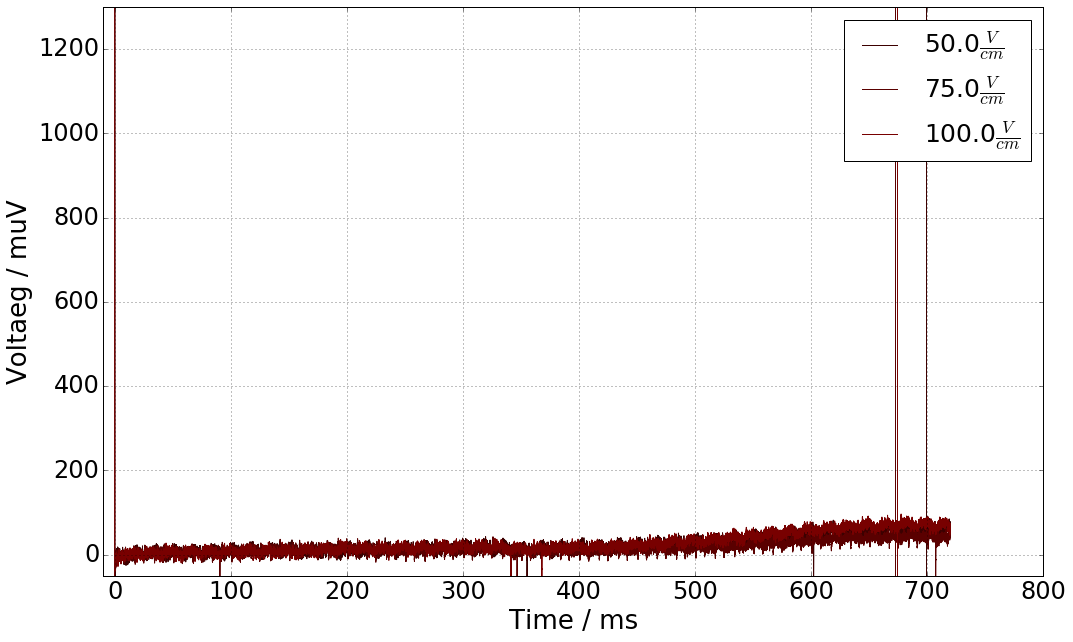

In [189]:
unit=  r"$\frac{V}{cm}$"
plt.figure(figsize=(15,9))
for x in range(0,len(paths)):
    plt.axvline(arrival[x],color=cm.afmhot((x+2)/17))
    tim = savgol_filter(TimeCorr[x],91,3)
    vol = savgol_filter(VoltCorr[x],91,3)
    plt.plot(tim,vol,label=str(Efield[x]) + unit,color=cm.afmhot((x+2)/17))
        #plt.plot(TimeCorr[x],VoltCorr[x],label=str(Efield[x]) + unit,color=cm.afmhot((x+2)/17))

#plt.text(325, -10, r'750 Torr', fontsize=30)
#plt.text(25, 10, r'RC=10$\mu$s', fontsize=30)
#plt.title('BTX ION drift 5-24-17 ',fontsize=30)
plt.xlim(-10,800)
plt.ylim(-50,1300)
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltaeg / muV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=25)
plt.tight_layout()
#plt.savefig('ION-075.pdf')

plt.show()

In [154]:
Efield[2:6]

array([ 100.,  125.,  150.,  175.])

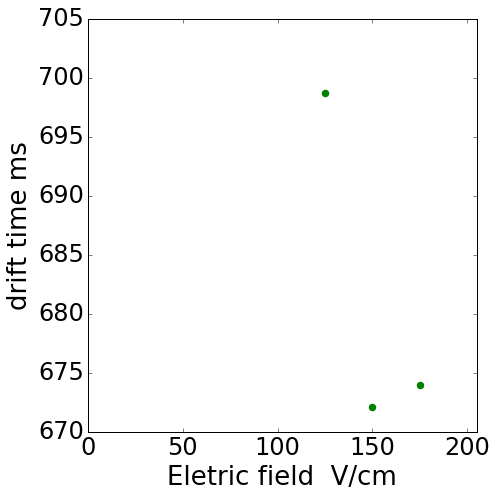

In [190]:
plt.figure(figsize=(7,7))
plt.scatter(Efield[3:6],arrival,linewidth=3,color='g')
plt.xlim(0,205)
#plt.ylim(90,140)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'drift time ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_velocity_5-24-17-2.pdf')

plt.show()

In [191]:
Te

array([ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110,
       115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175,
       180, 185, 190, 195])

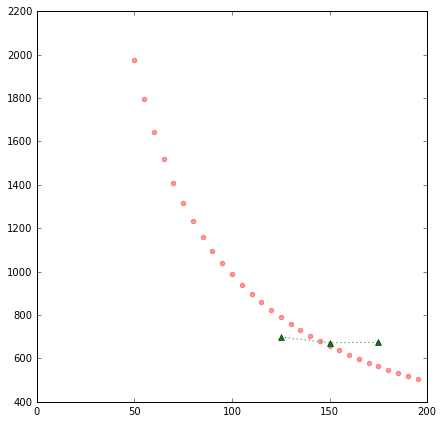

array([ 0.02027054])

In [192]:
Te = np.arange(50, 200, 5)
x = Efield[3:6]
y = arrival
def srt(E,k0):
    return 1/k0*20/E
popt,pcov =curve_fit(srt,  x,  y)
plt.figure(figsize=(7,7))
plt.plot(x,y,'g^:',label='data')
plt.scatter(Te,srt(Te,*popt),color='r',alpha=0.4)
plt.xlim(0,200)
#plt.ylim(0,200)
plt.show()
popt*100

In [119]:
pressure[0:6]

['0.75bar', '1bar', '2bar', '3bar', '4bar', '5bar']

In [193]:
popt*100 #converts it to seconds

array([ 0.02027054])

In [194]:
RudMob = np.array([0.20322658,0.08902632,0.06948859,0.05332866,0.03035011,0.02550635,0.02250192,0.02027054])
press  = np.array([0.75,1,2,3,4,5,6,7])

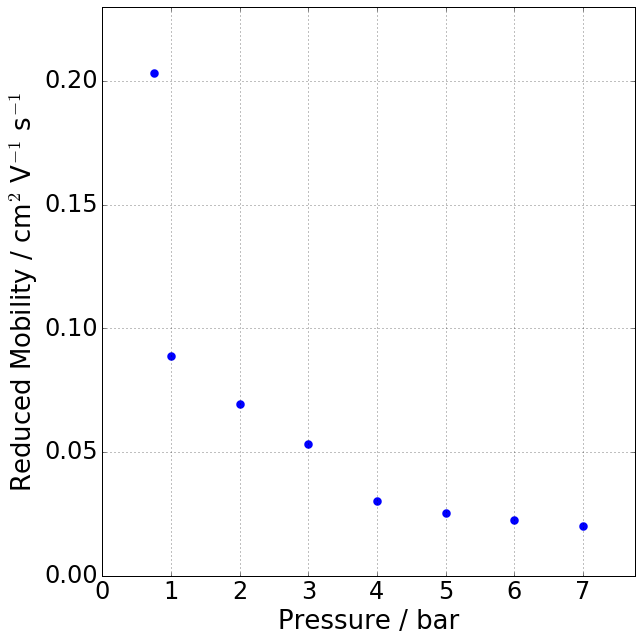

In [205]:
plt.figure(figsize=(9,9))
plt.scatter(press,RudMob,linewidth=4,color='blue')
plt.xlim(0,7.75)
plt.ylim(0,0.23)
plt.xlabel(r'Pressure / bar',fontsize=26)
plt.ylabel(r'Reduced Mobility / cm$^2$ V$^{-1}$ s$^{-1}$',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.grid()
#plt.savefig('Ar mobility.pdf')

plt.show()

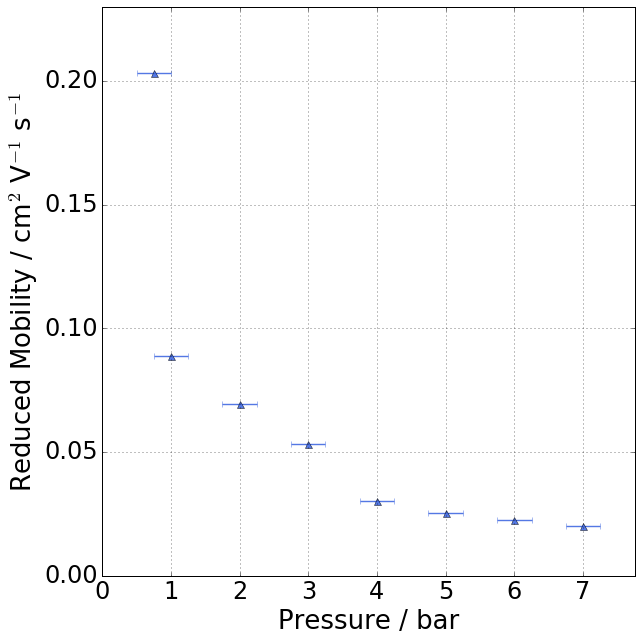

In [211]:
plt.figure(figsize=(9,9))
plt.errorbar(press,RudMob,yerr=0.0,xerr=0.25
             ,color='royalblue' ,alpha=0.9,fmt='^',markersize=7,linewidth=1.4)
plt.xlim(0,7.75)
plt.ylim(0,0.23)
plt.xlabel(r'Pressure / bar',fontsize=26)
plt.ylabel(r'Reduced Mobility / cm$^2$ V$^{-1}$ s$^{-1}$',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.grid()
#plt.savefig('Ar mobility.pdf')

plt.show()

In [35]:
Fdata = []
Ftime = []
for x in range(2,len(paths)):
    Fdata.append(((Volt[x]+abs(np.mean(Volt[x][0:9000])))*ml)[12000:])
    Ftime.append((Time[x]*ml)[12000:])

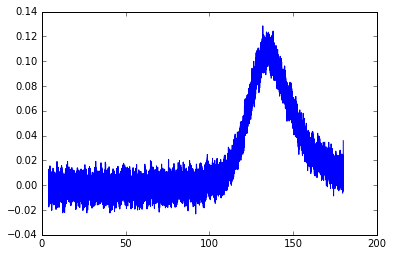

In [77]:
for x in range(0,1):
    plt.plot(Ftime[x],Fdata[x])

In [49]:
MeanLoc = np.where(Fdata[0]==max(Fdata[0]))[0][0]
Mean = Ftime[0][aa]

131.93447988286135

In [32]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_fit_vals(dataX,dataY):
    maxx = max(dataY)
    sig_val = maxx*0.5
    MeanLoc = np.where(dataY==max(dataY))[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    sigma_point = (Rpoint-Lpoint)/2   
    return (Mean,sigma_point)

In [33]:
FitVals = []
for q in range(0,len(paths)-2):
    x = Ftime[q]
    y = Fdata[q]
    aa = find_fit_vals(x,y)
    popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), aa[0], aa[1]])
    FitVals.append(popt)
    

NameError: name 'Ftime' is not defined

In [105]:
cut =9000
arrival=[]
velocity=[]
for x in range(0,len(paths)):
    mins=max(VoltCorr[x][cut:])
    arrival.append( TimeCorr[x][cut:][np.where(VoltCorr[x][cut:]==mins)[0][0]])
    velocity.append(20/ (TimeCorr[x][cut:][np.where(VoltCorr[x][cut:]==mins)[0][0]]))


In [101]:
arrival

[163.80762699636637,
 139.74737350361283,
 114.69991664253239,
 102.51795855095176,
 91.673700894307117,
 78.93612393298217]

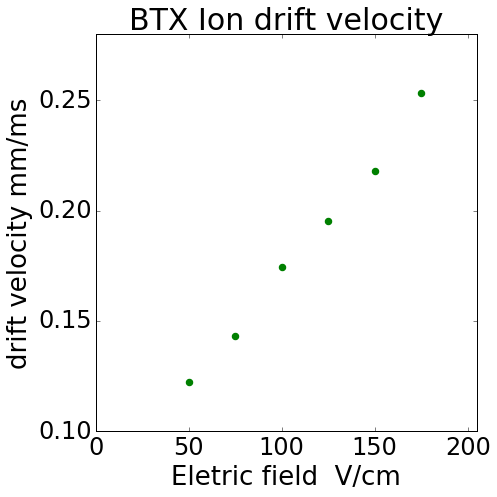

In [106]:
plt.figure(figsize=(7,7))
plt.scatter(Efield,velocity,linewidth=3,color='g')
plt.title('BTX Ion drift velocity',fontsize=30)
plt.xlim(0,205)
#plt.ylim(90,140)
plt.xlabel(r'Eletric field  V/cm',fontsize=26)
plt.ylabel(r'drift velocity mm/ms',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
#plt.savefig('BTX_ION_drift_velocity_5-24-17-2.pdf')

plt.show()

In [107]:
np.polyfit(Efield,velocity, 1)

array([ 0.00103114,  0.06836393])